<a href="https://colab.research.google.com/github/MerkulovDaniil/optim/blob/master/assets/Notebooks/SGD_and_variations_ISP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Examples

[source](https://d2l.ai/chapter_optimization/index.html)

<a name="sgd"></a>
## Stochastic Gradient Descent


In [ ]:
!pip install d2l==0.16.1

from IPython.display import clear_output
clear_output()

In this section, we are going to introduce the basic principles of stochastic gradient descent.


In [ ]:
%matplotlib inline
from matplotlib import pyplot as plt
from d2l import torch as d2l
import math
import torch

### Stochastic Gradient Updates

In deep learning, the objective function is usually the average of the loss functions for each example in the training dataset. We assume that $f_i(\mathbf{x})$ is the loss function of the training dataset with $n$ examples, an index of $i$, and parameter vector of $\mathbf{x}$, then we have the objective function

$$f(\mathbf{x}) = \frac{1}{n} \sum_{i = 1}^n f_i(\mathbf{x}).$$

The gradient of the objective function at $\mathbf{x}$ is computed as

$$\nabla f(\mathbf{x}) = \frac{1}{n} \sum_{i = 1}^n \nabla f_i(\mathbf{x}).$$

If gradient descent is used, the computing cost for each independent variable iteration is $\mathcal{O}(n)$, which grows linearly with $n$. Therefore, when the model training dataset is large, the cost of gradient descent for each iteration will be very high.

Stochastic gradient descent (SGD) reduces computational cost at each iteration. At each iteration of stochastic gradient descent, we uniformly sample an index $i\in\{1,\ldots, n\}$ for data examples at random, and compute the gradient $\nabla f_i(\mathbf{x})$ to update $\mathbf{x}$:

$$\mathbf{x} \leftarrow \mathbf{x} - \eta \nabla f_i(\mathbf{x}).$$

Here, $\eta$ is the learning rate. We can see that the computing cost for each iteration drops from $\mathcal{O}(n)$ of the gradient descent to the constant $\mathcal{O}(1)$. We should mention that the stochastic gradient $\nabla f_i(\mathbf{x})$ is the unbiased estimate of gradient $\nabla f(\mathbf{x})$.

$$\mathbb{E}_i \nabla f_i(\mathbf{x}) = \frac{1}{n} \sum_{i = 1}^n \nabla f_i(\mathbf{x}) = \nabla f(\mathbf{x}).$$

This means that, on average, the stochastic gradient is a good estimate of the gradient.

Now, we will compare it to gradient descent by adding random noise with a mean of 0 and a variance of 1 to the gradient to simulate a SGD.


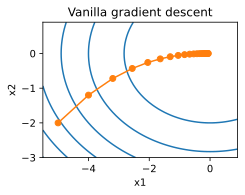

In [ ]:
f = lambda x1, x2: x1 ** 2 + 2 * x2 ** 2  # Objective
gradf = lambda x1, x2: (2 * x1, 4 * x2)  # Gradient

def train_2d(trainer, steps=20): 
    """Optimize a 2-dim objective function with a customized trainer."""
    # s1 and s2 are internal state variables and will
    # be used later in the chapter
    x1, x2, s1, s2 = -5, -2, 0, 0
    results = [(x1, x2)]
    for i in range(steps):
        x1, x2, s1, s2 = trainer(x1, x2, s1, s2)
        results.append((x1, x2))
    return results

def show_trace_2d(f, results):
    """Show the trace of 2D variables during optimization."""
    d2l.set_figsize()
    d2l.plt.plot(*zip(*results), '-o', color='#ff7f0e')
    x1, x2 = torch.meshgrid(torch.arange(-5.5, 1.0, 0.1),
                          torch.arange(-3.0, 1.0, 0.1))
    d2l.plt.contour(x1, x2, f(x1, x2), colors='#1f77b4')
    d2l.plt.xlabel('x1')
    d2l.plt.ylabel('x2')

def gd(x1, x2, s1, s2):
    (g1, g2) = gradf(x1, x2)  # Compute gradient
    return (x1 - eta * g1, x2 - eta * g2, 0, 0)  # Update variables

eta = 0.1
plt.title("Vanilla gradient descent")
show_trace_2d(f, train_2d(gd))

/usr/local/lib/python3.7/dist-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


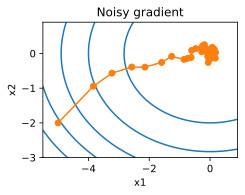

In [ ]:
f = lambda x1, x2: x1 ** 2 + 2 * x2 ** 2  # Objective
gradf = lambda x1, x2: (2 * x1, 4 * x2)  # Gradient

def sgd(x1, x2, s1, s2):
    global lr  # Learning rate scheduler
    (g1, g2) = gradf(x1, x2)
    # Simulate noisy gradient
    g1 += torch.normal(0.0, 1, (1,))
    g2 += torch.normal(0.0, 1, (1,))
    eta_t = eta * lr()  # Learning rate at time t
    return (x1 - eta_t * g1, x2 - eta_t * g2, 0, 0)  # Update variables

eta = 0.1
lr = (lambda: 1)  # Constant learning rate
plt.title("Noisy gradient")
d2l.show_trace_2d(f, d2l.train_2d(sgd, steps=50))

As we can see, the trajectory of the variables in the SGD is much more noisy than the one we observed in gradient descent in the previous section. This is due to the stochastic nature of the gradient. That is, even when we arrive near the minimum, we are still subject to the uncertainty injected by the instantaneous gradient via $\eta \nabla f_i(\mathbf{x})$. Even after 50 steps the quality is still not so good. Even worse, it will not improve after additional steps (we encourage the reader to experiment with a larger number of steps to confirm this on his own). This leaves us with the only alternative---change the learning rate $\eta$. However, if we pick this too small, we will not make any meaningful progress initially. On the other hand, if we pick it too large, we will not get a good solution, as seen above. The only way to resolve these conflicting goals is to reduce the learning rate *dynamically* as optimization progresses.

This is also the reason for adding a learning rate function `lr` into the `sgd` step function. In the example above any functionality for learning rate scheduling lies dormant as we set the associated `lr` function to be constant, i.e., `lr = (lambda: 1)`.

### Dynamic Learning Rate

Replacing $\eta$ with a time-dependent learning rate $\eta(t)$ adds to the complexity of controlling convergence of an optimization algorithm. In particular, need to figure out how rapidly $\eta$ should decay. If it is too quick, we will stop optimizing prematurely. If we decrease it too slowly, we waste too much time on optimization. There are a few basic strategies that are used in adjusting $\eta$ over time (we will discuss more advanced strategies in a later chapter):

$$
\begin{aligned}
    \eta(t) & = \eta_i \text{ if } t_i \leq t \leq t_{i+1}  && \mathrm{piecewise~constant} \\
    \eta(t) & = \eta_0 \cdot e^{-\lambda t} && \mathrm{exponential} \\
    \eta(t) & = \eta_0 \cdot (\beta t + 1)^{-\alpha} && \mathrm{polynomial}
\end{aligned}
$$

In the first scenario we decrease the learning rate, e.g., whenever progress in optimization has stalled. This is a common strategy for training deep networks. Alternatively we could decrease it much more aggressively by an exponential decay. Unfortunately this leads to premature stopping before the algorithm has converged. A popular choice is polynomial decay with $\alpha = 0.5$. In the case of convex optimization there are a number of proofs which show that this rate is well behaved. Let us see what this looks like in practice.


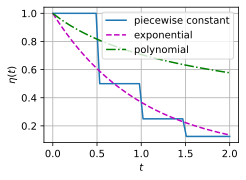

In [ ]:
import numpy as np
t = np.linspace(0,2)
def piecewise_constant(t, eta_0 = 1):
    return (0 <= t)*(t < 0.5)*eta_0 + (0.5 <= t)*(t < 1)*eta_0/2 + (1 <= t)*(t < 1.5)*eta_0/4 + (t >=1.5)*eta_0/8

def exponential(t, eta_0 = 1, lambda_ = 1):
    return eta_0*np.exp(-lambda_*t)

def polynomial(t, eta_0 = 1, alpha = 0.5, beta = 1):
    return eta_0*(beta*t + 1)**(-alpha)

d2l.plot(t, [piecewise_constant(t), exponential(t), polynomial(t)], legend=['piecewise constant', 'exponential', 'polynomial'], xlabel='$t$', ylabel=f'$\eta(t)$')

/usr/local/lib/python3.7/dist-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


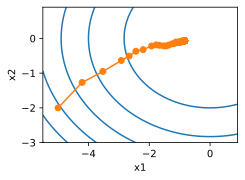

In [ ]:
def exponential():
    global ctr
    ctr += 1
    return math.exp(-0.1 * ctr)

ctr = 1
lr = exponential  # Set up learning rate
d2l.show_trace_2d(f, d2l.train_2d(sgd, steps=1000))

As expected, the variance in the parameters is significantly reduced. However, this comes at the expense of failing to converge to the optimal solution $\mathbf{x} = (0, 0)$. Even after 1000 steps are we are still very far away from the optimal solution. Indeed, the algorithm fails to converge at all. On the other hand, if we use a polynomial decay where the learning rate decays with the inverse square root of the number of steps convergence is good.


/usr/local/lib/python3.7/dist-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


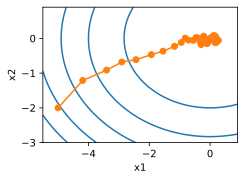

In [ ]:
def polynomial():
    global ctr
    ctr += 1
    return (1 + 0.1 * ctr)**(-0.5)

ctr = 1
lr = polynomial  # Set up learning rate
d2l.show_trace_2d(f, d2l.train_2d(sgd, steps=50))

There exist many more choices for how to set the learning rate. For instance, we could start with a small rate, then rapidly ramp up and then decrease it again, albeit more slowly. We could even alternate between smaller and larger learning rates. There exists a large variety of such schedules. For now let us focus on learning rate schedules for which a comprehensive theoretical analysis is possible, i.e., on learning rates in a convex setting. For general nonconvex problems it is very difficult to obtain meaningful convergence guarantees, since in general minimizing nonlinear nonconvex problems is NP hard. For a survey see e.g., the excellent [lecture notes](https://www.stat.cmu.edu/~ryantibs/convexopt-F15/lectures/26-nonconvex.pdf) of Tibshirani 2015.


## Summary

* For convex problems we can prove that for a wide choice of learning rates Stochastic Gradient Descent will converge to the optimal solution.
* For deep learning this is generally not the case. However, the analysis of convex problems gives us useful insight into how to approach optimization, namely to reduce the learning rate progressively, albeit not too quickly.
* Problems occur when the learning rate is too small or too large. In practice  a suitable learning rate is often found only after multiple experiments.
* When there are more examples in the training dataset, it costs more to compute each iteration for gradient descent, so SGD is preferred in these cases.
* Optimality guarantees for SGD are in general not available in nonconvex cases since the number of local minima that require checking might well be exponential.


<a name="minibatchsgd"></a>
## Minibatch stochastic gradient descent

So far we encountered two extremes in the approach to gradient based learning: Vanilla gradient descent uses the full dataset to compute gradients and to update parameters, one pass at a time. Conversely stochastic gradient descent processes one observation at a time to make progress. Each of them has its own drawbacks. Gradient Descent is not particularly *data efficient* whenever data is very similar. Stochastic Gradient Descent is not particularly *computationally efficient* since CPUs and GPUs cannot exploit the full power of vectorization. This suggests that there might be a happy medium, and in fact, that's what we have been using so far in the examples we discussed.

### Vectorization and Caches

At the heart of the decision to use minibatches is computational efficiency. This is most easily understood when considering parallelization to multiple GPUs and multiple servers. In this case we need to send at least one image to each GPU. With 8 GPUs per server and 16 servers we already arrive at a minibatch size of 128.

Things are a bit more subtle when it comes to single GPUs or even CPUs. These devices have multiple types of memory, often multiple type of compute units and different bandwidth constraints between them. For instance, a CPU has a small number of registers and then L1, L2 and in some cases even L3 cache (which is shared between the different processor cores). These caches are of increasing size and latency (and at the same time they are of decreasing bandwidth). Suffice it to say, the processor is capable of performing many more operations than what the main memory interface is able to provide.

* A 2GHz CPU with 16 cores and AVX-512 vectorization can process up to $2 \cdot 10^9 \cdot 16 \cdot 32 = 10^{12}$ bytes per second. The capability of GPUs easily exceeds this number by a factor of 100. On the other hand, a midrange server processor might not have much more than 100 GB/s bandwidth, i.e., less than one tenth of what would be required to keep the processor fed. To make matters worse, not all memory access is created equal: first, memory interfaces are typically 64 bit wide or wider (e.g., on GPUs up to 384 bit), hence reading a single byte incurs the cost of a much wider access.
* There is significant overhead for the first access whereas sequential access is relatively cheap (this is often called a burst read). There are many more things to keep in mind, such as caching when we have multiple sockets, chiplets and other structures. A detailed discussion of this is beyond the scope of this section. See e.g., this [Wikipedia article](https://en.wikipedia.org/wiki/Cache_hierarchy) for a more in-depth discussion.

The way to alleviate these constraints is to use a hierarchy of CPU caches which are actually fast enough to supply the processor with data. This is *the* driving force behind batching in deep learning. To keep matters simple, consider matrix-matrix multiplication, say $\mathbf{A} = \mathbf{B}\mathbf{C}$. We have a number of options for calculating $\mathbf{A}$. For instance we could try the following:

1. We could compute $\mathbf{A}_{ij} = \mathbf{B}_{i,:} \mathbf{C}_{:,j}^\top$, i.e., we could compute it elementwise by means of dot products.
1. We could compute $\mathbf{A}_{:,j} = \mathbf{B} \mathbf{C}_{:,j}^\top$, i.e., we could compute it one column at a time. Likewise we could compute $\mathbf{A}$ one row $\mathbf{A}_{i,:}$ at a time.
1. We could simply compute $\mathbf{A} = \mathbf{B} \mathbf{C}$.
1. We could break $\mathbf{B}$ and $\mathbf{C}$ into smaller block matrices and compute $\mathbf{A}$ one block at a time.

If we follow the first option, we will need to copy one row and one column vector into the CPU each time we want to compute an element $\mathbf{A}_{ij}$. Even worse, due to the fact that matrix elements are aligned sequentially we are thus required to access many disjoint locations for one of the two vectors as we read them from memory. The second option is much more favorable. In it, we are able to keep the column vector $\mathbf{C}_{:,j}$ in the CPU cache while we keep on traversing through $B$. This halves the memory bandwidth requirement with correspondingly faster access. Of course, option 3 is most desirable. Unfortunately, most matrices might not entirely fit into cache (this is what we are discussing after all). However, option 4 offers a practically useful alternative: we can move blocks of the matrix into cache and multiply them locally. Optimized libraries take care of this for us. Let us have a look at how efficient these operations are in practice.

Beyond computational efficiency, the overhead introduced by Python and by the deep learning framework itself is considerable. Recall that each time we execute a command the Python interpreter sends a command to the MXNet engine which needs to insert it into the computational graph and deal with it during scheduling. Such overhead can be quite detrimental. In short, **it is highly advisable to use vectorization (and matrices) whenever possible.**


In [ ]:
%matplotlib inline
from d2l import torch as d2l
import torch
from torch import nn
import numpy as np

timer = d2l.Timer()
A = torch.zeros(256, 256)
B = torch.randn(256, 256)
C = torch.randn(256, 256)

Element-wise assignment simply iterates over all rows and columns of $\mathbf{B}$ and $\mathbf{C}$ respectively to assign the value to $\mathbf{A}$.


In [ ]:
# Compute A = BC one element at a time
timer.start()
for i in range(256):
    for j in range(256):
        A[i, j] = torch.dot(B[i, :], C[:, j])
timer.stop()

0.9076807498931885

A faster strategy is to perform column-wise assignment.


In [ ]:
# Compute A = BC one column at a time
timer.start()
for j in range(256):
    A[:, j] = torch.mv(B, C[:, j])
timer.stop()

0.014197111129760742

Last, the most effective manner is to perform the entire operation in one block. Let us see what the respective speed of the operations is.


In [ ]:
# Compute A = BC in one go
timer.start()
A = torch.mm(B, C)
timer.stop()

0.042726993560791016

In [ ]:
# Multiply and add count as separate operations (fused in practice)
gigaflops = [2/i for i in timer.times]
print(f'performance in Gigaflops: element {gigaflops[0]:.3f}, '
      f'column {gigaflops[1]:.3f}, full {gigaflops[2]:.3f}')

performance in Gigaflops: element 2.203, column 140.874, full 46.809


### Minibatches

In the past we took it for granted that we would read *minibatches* of data rather than single observations to update parameters. We now give a brief justification for it. Processing single observations requires us to perform many single matrix-vector (or even vector-vector) multiplications, which is quite expensive and which incurs a significant overhead on behalf of the underlying deep learning framework. This applies both to evaluating a network when applied to data (often referred to as inference) and when computing gradients to update parameters. That is, this applies whenever we perform $\mathbf{w} \leftarrow \mathbf{w} - \eta_t \mathbf{g}_t$ where

$$\mathbf{g}_t = \partial_{\mathbf{w}} f(\mathbf{x}_{t}, \mathbf{w})$$

We can increase the *computational* efficiency of this operation by applying it to a minibatch of observations at a time. That is, we replace the gradient $\mathbf{g}_t$ over a single observation by one over a small batch

$$\mathbf{g}_t = \partial_{\mathbf{w}} \frac{1}{|\mathcal{B}_t|} \sum_{i \in \mathcal{B}_t} f(\mathbf{x}_{i}, \mathbf{w})$$

Let us see what this does to the statistical properties of $\mathbf{g}_t$: since both $\mathbf{x}_t$ and also all elements of the minibatch $\mathcal{B}_t$ are drawn uniformly at random from the training set, the expectation of the gradient remains unchanged. The variance, on the other hand, is reduced significantly. Since the minibatch gradient is composed of $b := |\mathcal{B}_t|$ independent gradients which are being averaged, its standard deviation is reduced by a factor of $b^{-\frac{1}{2}}$. This, by itself, is a good thing, since it means that the updates are more reliably aligned with the full gradient.

Naively this would indicate that choosing a large minibatch $\mathcal{B}_t$ would be universally desirable. Alas, after some point, the additional reduction in standard deviation is minimal when compared to the linear increase in computational cost. In practice we pick a minibatch that is large enough to offer good computational efficiency while still fitting into the memory of a GPU. To illustrate the savings let us have a look at some code. In it we perform the same matrix-matrix multiplication, but this time broken up into "minibatches" of 64 columns at a time.


In [ ]:
timer.start()
for j in range(0, 256, 64):
    A[:, j:j+64] = torch.mm(B, C[:, j:j+64])
timer.stop()
print(f'performance in Gigaflops: block {2 / timer.times[3]:.3f}')

performance in Gigaflops: block 245.460


As we can see, the computation on the minibatch is essentially as efficient as on the full matrix. A word of caution is in order. In minibatch SGD we used a type of regularization that was heavily dependent on the amount of variance in a minibatch. As we increase the latter, the variance decreases and with it the benefit of the noise-injection due to batch normalization. 

### Reading the Dataset

Let us have a look at how minibatches are efficiently generated from data. In the following we use a dataset developed by NASA to test the wing [noise from different aircraft](https://archive.ics.uci.edu/ml/datasets/Airfoil+Self-Noise) to compare these optimization algorithms. For convenience we only use the first $1,500$ examples. The data is whitened for preprocessing, i.e., we remove the mean and rescale the variance to $1$ per coordinate.


In [ ]:
d2l.DATA_HUB['airfoil'] = (d2l.DATA_URL + 'airfoil_self_noise.dat',
                           '76e5be1548fd8222e5074cf0faae75edff8cf93f')

def get_data_ch11(batch_size=10, n=1500):
    data = np.genfromtxt(d2l.download('airfoil'),
                         dtype=np.float32, delimiter='\t')
    data = torch.from_numpy((data - data.mean(axis=0)) / data.std(axis=0))
    data_iter = d2l.load_array((data[:n, :-1], data[:n, -1]),
                               batch_size, is_train=True)
    return data_iter, data.shape[1]-1

### Implementation from Scratch

Recall the minibatch SGD implementation from :numref:`sec_linear_scratch`. In the following we provide a slightly more general implementation. For convenience it has the same call signature as the other optimization algorithms introduced later in this chapter. Specifically, we add the status
input `states` and place the hyperparameter in dictionary `hyperparams`. In
addition, we will average the loss of each minibatch example in the training
function, so the gradient in the optimization algorithm does not need to be
divided by the batch size.


In [ ]:
def sgd(params, states, hyperparams):
    for p in params:
        p.data.sub_(hyperparams['lr'] * p.grad)
        p.grad.data.zero_()

Next, we implement a generic training function to facilitate the use of the other optimization algorithms introduced later in this chapter. It initializes a linear regression model and can be used to train the model with minibatch SGD and other algorithms introduced subsequently.


In [ ]:
def train_ch11(trainer_fn, states, hyperparams, data_iter,
               feature_dim, num_epochs=2):
    # Initialization
    w = torch.normal(mean=0.0, std=0.01, size=(feature_dim, 1),
                     requires_grad=True)
    b = torch.zeros((1), requires_grad=True)
    net, loss = lambda X: d2l.linreg(X, w, b), d2l.squared_loss
    # Train
    animator = d2l.Animator(xlabel='epoch', ylabel='loss',
                            xlim=[0, num_epochs], ylim=[0.22, 0.35])
    n, timer = 0, d2l.Timer()
    for _ in range(num_epochs):
        for X, y in data_iter:
            l = loss(net(X), y).mean()
            l.backward()
            trainer_fn([w, b], states, hyperparams)
            n += X.shape[0]
            if n % 200 == 0:
                timer.stop()
                animator.add(n/X.shape[0]/len(data_iter),
                             (d2l.evaluate_loss(net, data_iter, loss),))
                timer.start()
    print(f'loss: {animator.Y[0][-1]:.3f}, {timer.avg():.3f} sec/epoch')
    return timer.cumsum(), animator.Y[0]

Let us see how optimization proceeds for batch gradient descent. This can be achieved by setting the minibatch size to 1500 (i.e., to the total number of examples). As a result the model parameters are updated only once per epoch. There is little progress. In fact, after 6 steps progress stalls.


loss: 0.247, 0.030 sec/epoch


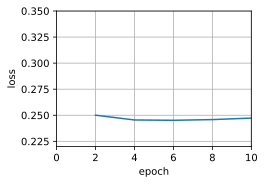

In [ ]:
def train_sgd(lr, batch_size, num_epochs=2):
    data_iter, feature_dim = get_data_ch11(batch_size)
    return train_ch11(
        sgd, None, {'lr': lr}, data_iter, feature_dim, num_epochs)

gd_res = train_sgd(1, 1500, 10)

When the batch size equals 1, we use SGD for optimization. For simplicity of implementation we picked a constant (albeit small) learning rate. In SGD, the model parameters are updated whenever an example is processed. In our case this amounts to 1500 updates per epoch. As we can see, the decline in the value of the objective function slows down after one epoch. Although both the procedures processed 1500 examples within one epoch, SGD consumes more time than gradient descent in our experiment. This is because SGD updated the parameters more frequently and since it is less efficient to process single observations one at a time.


loss: 0.244, 0.060 sec/epoch


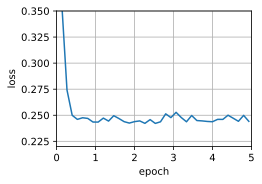

In [ ]:
sgd_res = train_sgd(0.005, 1, 5)

Finally, when the batch size equals 100, we use minibatch SGD for optimization. The time required per epoch is shorter than the time needed for SGD and the time for batch gradient descent.


loss: 0.245, 0.004 sec/epoch


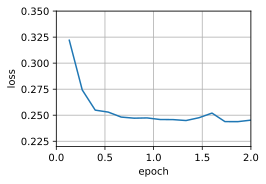

In [ ]:
mini1_res = train_sgd(.4, 100)

Reducing the batch size to 10, the time for each epoch increases because the workload for each batch is less efficient to execute.


loss: 0.246, 0.013 sec/epoch


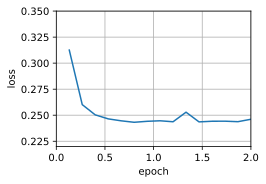

In [ ]:
mini2_res = train_sgd(.05, 10)

Now we can compare the time vs. loss for the previous four experiments. As can be seen, although SGD converges faster than GD in terms of number of examples processed, it uses more time to reach the same loss than GD because computing the gradient example by example is not as efficient. Minibatch SGD is able to trade-off convergence speed and computation efficiency. A minibatch size of 10 is more efficient than SGD; a minibatch size of 100 even outperforms GD in terms of runtime.


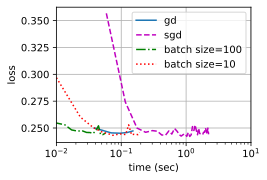

In [ ]:
d2l.set_figsize([6, 3])
d2l.plot(*list(map(list, zip(gd_res, sgd_res, mini1_res, mini2_res))),
         'time (sec)', 'loss', xlim=[1e-2, 10],
         legend=['gd', 'sgd', 'batch size=100', 'batch size=10'])
d2l.plt.gca().set_xscale('log')

### Concise Implementation


In [ ]:
def train_concise_ch11(trainer_fn, hyperparams, data_iter, num_epochs=4):
    # Initialization
    net = nn.Sequential(nn.Linear(5, 1))
    def init_weights(m):
        if type(m) == nn.Linear:
            torch.nn.init.normal_(m.weight, std=0.01)
    net.apply(init_weights)

    optimizer = trainer_fn(net.parameters(), **hyperparams)

    loss = nn.MSELoss()
    # Note: L2 Loss = 1/2 * MSE Loss. PyTorch has MSE Loss which is slightly
    # different from MXNet's L2Loss by a factor of 2. Hence we halve the loss
    # value to get L2Loss in PyTorch
    animator = d2l.Animator(xlabel='epoch', ylabel='loss',
                            xlim=[0, num_epochs], ylim=[0.22, 0.35])
    n, timer = 0, d2l.Timer()
    for _ in range(num_epochs):
        for X, y in data_iter:
            optimizer.zero_grad()
            out = net(X)
            y = y.reshape(out.shape)
            l = loss(out, y)/2
            l.backward()
            optimizer.step()
            n += X.shape[0]
            if n % 200 == 0:
                timer.stop()
                animator.add(n/X.shape[0]/len(data_iter),
                             (d2l.evaluate_loss(net, data_iter, loss)/2,))
                timer.start()
    print(f'loss: {animator.Y[0][-1]:.3f}, {timer.avg():.3f} sec/epoch')

loss: 0.245, 0.014 sec/epoch


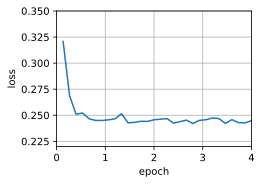

In [ ]:
data_iter, _ = get_data_ch11(10)
trainer = torch.optim.SGD
train_concise_ch11(trainer, {'lr': 0.05}, data_iter)

### Summary

* Vectorization makes code more efficient due to reduced overhead arising from the deep learning framework and due to better memory locality and caching on CPUs and GPUs.
* There is a trade-off between statistical efficiency arising from SGD and computational efficiency arising from processing large batches of data at a time.
* Minibatch stochastic gradient descent offers the best of both worlds: computational and statistical efficiency.
* In minibatch SGD we process batches of data obtained by a random permutation of the training data (i.e., each observation is processed only once per epoch, albeit in random order).
* It is advisable to decay the learning rates during training.
* In general, minibatch SGD is faster than SGD and gradient descent for convergence to a smaller risk, when measured in terms of clock time.


<a name="momentumsgd"></a>
## Momentum

In SGD we reviewed what happens when performing stochastic gradient descent, i.e., when performing optimization where only a noisy variant of the gradient is available. In particular, we noticed that for noisy gradients we need to be extra cautious when it comes to choosing the learning rate in the face of noise. If we decrease it too rapidly, convergence stalls. If we are too lenient, we fail to converge to a good enough solution since noise keeps on driving us away from optimality.

### Basics

In this section, we will explore more effective optimization algorithms, especially for certain types of optimization problems that are common in practice.


#### Leaky Averages

The previous section saw us discussing minibatch SGD as a means for accelerating computation. It also had the nice side-effect that averaging gradients reduced the amount of variance. The minibatch SGD can be calculated by:

$$
\mathbf{g}_{t, t-1} = \partial_{\mathbf{w}} \frac{1}{|\mathcal{B}_t|} \sum_{i \in \mathcal{B}_t} f(\mathbf{x}_{i}, \mathbf{w}_{t-1}) = \frac{1}{|\mathcal{B}_t|} \sum_{i \in \mathcal{B}_t} \mathbf{h}_{i, t-1}.
$$

To keep the notation simple, here we used $\mathbf{h}_{i, t-1} = \partial_{\mathbf{w}} f(\mathbf{x}_i, \mathbf{w}_{t-1})$ as the SGD for sample $i$ using the weights updated at time $t-1$.
It would be nice if we could benefit from the effect of variance reduction even beyond averaging gradients on a minibatch. One option to accomplish this task is to replace the gradient computation by a "leaky average":

$$
\mathbf{v}_t = \beta \mathbf{v}_{t-1} + \mathbf{g}_{t, t-1}
$$

for some $\beta \in (0, 1)$. This effectively replaces the instantaneous gradient by one that's been averaged over multiple *past* gradients. $\mathbf{v}$ is called *momentum*. It accumulates past gradients similar to how a heavy ball rolling down the objective function landscape integrates over past forces. To see what is happening in more detail let us expand $\mathbf{v}_t$ recursively into

$$
\begin{aligned}
\mathbf{v}_t = \beta^2 \mathbf{v}_{t-2} + \beta \mathbf{g}_{t-1, t-2} + \mathbf{g}_{t, t-1}
= \ldots, = \sum_{\tau = 0}^{t-1} \beta^{\tau} \mathbf{g}_{t-\tau, t-\tau-1}.
\end{aligned}
$$

Large $\beta$ amounts to a long-range average, whereas small $\beta$ amounts to only a slight correction relative to a gradient method. The new gradient replacement no longer points into the direction of steepest descent on a particular instance any longer but rather in the direction of a weighted average of past gradients. This allows us to realize most of the benefits of averaging over a batch without the cost of actually computing the gradients on it. We will revisit this averaging procedure in more detail later.

The above reasoning formed the basis for what is now known as *accelerated* gradient methods, such as gradients with momentum. They enjoy the additional benefit of being much more effective in cases where the optimization problem is ill-conditioned (i.e., where there are some directions where progress is much slower than in others, resembling a narrow canyon). Furthermore, they allow us to average over subsequent gradients to obtain more stable directions of descent. Indeed, the aspect of acceleration even for noise-free convex problems is one of the key reasons why momentum works and why it works so well.

As one would expect, due to its efficacy momentum is a well-studied subject in optimization for deep learning and beyond. See e.g., the beautiful [expository article](https://distill.pub/2017/momentum/) by :cite:`Goh.2017` for an in-depth analysis and interactive animation. It was proposed by :cite:`Polyak.1964`. :cite:`Nesterov.2018` has a detailed theoretical discussion in the context of convex optimization. Momentum in deep learning has been known to be beneficial for a long time. See e.g., the discussion by :cite:`Sutskever.Martens.Dahl.ea.2013` for details.

#### An Ill-conditioned Problem

To get a better understanding of the geometric properties of the momentum method we revisit gradient descent, albeit with a significantly less pleasant objective function. Recall that in :numref:`sec_gd` we used $f(\mathbf{x}) = x_1^2 + 2 x_2^2$, i.e., a moderately distorted ellipsoid objective. We distort this function further by stretching it out in the $x_1$ direction via

$$f(\mathbf{x}) = 0.1 x_1^2 + 2 x_2^2.$$

As before $f$ has its minimum at $(0, 0)$. This function is *very* flat in the direction of $x_1$. Let us see what happens when we perform gradient descent as before on this new function. We pick a learning rate of $0.4$.


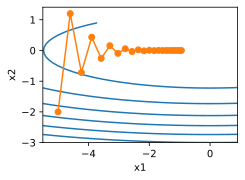

In [ ]:
%matplotlib inline
from d2l import torch as d2l
import torch

eta = 0.4
def f_2d(x1, x2):
    return 0.1 * x1 ** 2 + 2 * x2 ** 2
def gd_2d(x1, x2, s1, s2):
    return (x1 - eta * 0.2 * x1, x2 - eta * 4 * x2, 0, 0)

d2l.show_trace_2d(f_2d, d2l.train_2d(gd_2d))

By construction, the gradient in the $x_2$ direction is *much* higher and changes much more rapidly than in the horizontal $x_1$ direction. Thus we are stuck between two undesirable choices: if we pick a small learning rate we ensure that the solution does not diverge in the $x_2$ direction but we are saddled with slow convergence in the $x_1$ direction. Conversely, with a large learning rate we progress rapidly in the $x_1$ direction but diverge in $x_2$. The example below illustrates what happens even after a slight increase in learning rate from $0.4$ to $0.6$. Convergence in the $x_1$ direction improves but the overall solution quality is much worse.


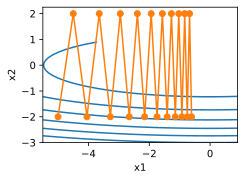

In [ ]:
eta = 0.5
d2l.show_trace_2d(f_2d, d2l.train_2d(gd_2d))

### The Momentum Method

The momentum method allows us to solve the gradient descent problem described
above. Looking at the optimization trace above we might intuit that averaging gradients over the past would work well. After all, in the $x_1$ direction this will aggregate well-aligned gradients, thus increasing the distance we cover with every step. Conversely, in the $x_2$ direction where gradients oscillate, an aggregate gradient will reduce step size due to oscillations that cancel each other out.
Using $\mathbf{v}_t$ instead of the gradient $\mathbf{g}_t$ yields the following update equations:

$$
\begin{aligned}
\mathbf{v}_t &\leftarrow \beta \mathbf{v}_{t-1} + \mathbf{g}_{t, t-1}, \\
\mathbf{x}_t &\leftarrow \mathbf{x}_{t-1} - \eta_t \mathbf{v}_t.
\end{aligned}
$$

Note that for $\beta = 0$ we recover regular gradient descent. Before delving deeper into the mathematical properties let us have a quick look at how the algorithm behaves in practice.


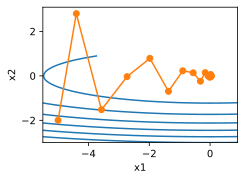

In [ ]:
def momentum_2d(x1, x2, v1, v2):
    v1 = beta * v1 + 0.2 * x1
    v2 = beta * v2 + 4 * x2
    return x1 - eta * v1, x2 - eta * v2, v1, v2

eta, beta = 0.6, 0.5
d2l.show_trace_2d(f_2d, d2l.train_2d(momentum_2d))

As we can see, even with the same learning rate that we used before, momentum still converges well. Let us see what happens when we decrease the momentum parameter. Halving it to $\beta = 0.25$ leads to a trajectory that barely converges at all. Nonetheless, it is a lot better than without momentum (when the solution diverges).


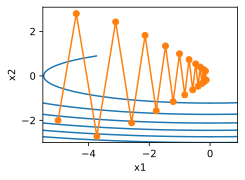

In [ ]:
eta, beta = 0.6, 0.25
d2l.show_trace_2d(f_2d, d2l.train_2d(momentum_2d))

### Practical Experiments

Let us see how momentum works in practice, i.e., when used within the context of a proper optimizer. For this we need a somewhat more scalable implementation.

#### Implementation from Scratch

Compared with (minibatch) SGD the momentum method needs to maintain a set of  auxiliary variables, i.e., velocity. It has the same shape as the gradients (and variables of the optimization problem). In the implementation below we call these variables `states`.


In [ ]:
def init_momentum_states(feature_dim):
    v_w = torch.zeros((feature_dim, 1))
    v_b = torch.zeros(1)
    return (v_w, v_b)

In [ ]:
def sgd_momentum(params, states, hyperparams):
    for p, v in zip(params, states):
        with torch.no_grad():
            v[:] = hyperparams['momentum'] * v + p.grad
            p[:] -= hyperparams['lr'] * v
        p.grad.data.zero_()

Let us see how this works in practice.


loss: 0.244, 0.013 sec/epoch


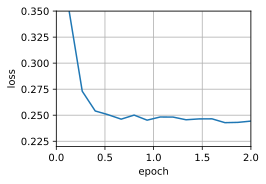

In [ ]:
def train_momentum(lr, momentum, num_epochs=2):
    d2l.train_ch11(sgd_momentum, init_momentum_states(feature_dim),
                   {'lr': lr, 'momentum': momentum}, data_iter,
                   feature_dim, num_epochs)

data_iter, feature_dim = d2l.get_data_ch11(batch_size=10)
train_momentum(0.02, 0.5)

When we increase the momentum hyperparameter `momentum` to 0.9, it amounts to a significantly larger effective sample size of $\frac{1}{1 - 0.9} = 10$. We reduce the learning rate slightly to $0.01$ to keep matters under control.


loss: 0.251, 0.015 sec/epoch


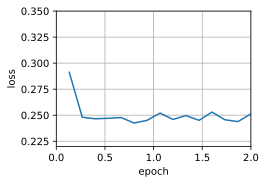

In [ ]:
train_momentum(0.01, 0.9)

Reducing the learning rate further addresses any issue of non-smooth optimization problems. Setting it to $0.005$ yields good convergence properties.


loss: 0.245, 0.015 sec/epoch


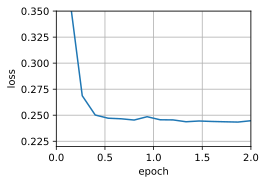

In [ ]:
train_momentum(0.005, 0.9)

#### Concise Implementation

There is very little to do in Gluon since the standard `sgd` solver already had momentum built in. Setting matching parameters yields a very similar trajectory.


loss: 0.247, 0.015 sec/epoch


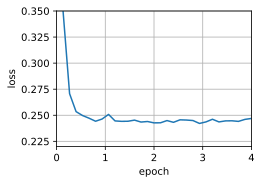

In [ ]:
trainer = torch.optim.SGD
d2l.train_concise_ch11(trainer, {'lr': 0.005, 'momentum': 0.9}, data_iter)

### Summary

* Momentum replaces gradients with a leaky average over past gradients. This accelerates convergence significantly.
* It is desirable for both noise-free gradient descent and (noisy) stochastic gradient descent.
* Momentum prevents stalling of the optimization process that is much more likely to occur for stochastic gradient descent.
* The effective number of gradients is given by $\frac{1}{1-\beta}$ due to exponentiated downweighting of past data.
* In the case of convex quadratic problems this can be analyzed explicitly in detail.
* Implementation is quite straightforward but it requires us to store an additional state vector (momentum $\mathbf{v}$).


<a name="adagrad"></a>
## AdaGrad

### The Algorithm

Let us formalize the discussion from above. We use the variable $\mathbf{s}_t$ to accumulate past gradient variance as follows.

$$\begin{aligned}
    \mathbf{g}_t & = \partial_{\mathbf{w}} l(y_t, f(\mathbf{x}_t, \mathbf{w})), \\
    \mathbf{s}_t & = \mathbf{s}_{t-1} + \mathbf{g}_t^2, \\
    \mathbf{w}_t & = \mathbf{w}_{t-1} - \frac{\eta}{\sqrt{\mathbf{s}_t + \epsilon}} \cdot \mathbf{g}_t.
\end{aligned}$$

Here the operation are applied coordinate wise. That is, $\mathbf{v}^2$ has entries $v_i^2$. Likewise $\frac{1}{\sqrt{v}}$ has entries $\frac{1}{\sqrt{v_i}}$ and $\mathbf{u} \cdot \mathbf{v}$ has entries $u_i v_i$. As before $\eta$ is the learning rate and $\epsilon$ is an additive constant that ensures that we do not divide by $0$. Last, we initialize $\mathbf{s}_0 = \mathbf{0}$.

Just like in the case of momentum we need to keep track of an auxiliary variable, in this case to allow for an individual learning rate per coordinate. This does not increase the cost of Adagrad significantly relative to SGD, simply since the main cost is typically to compute $l(y_t, f(\mathbf{x}_t, \mathbf{w}))$ and its derivative.

Note that accumulating squared gradients in $\mathbf{s}_t$ means that $\mathbf{s}_t$ grows essentially at linear rate (somewhat slower than linearly in practice, since the gradients initially diminish). This leads to an $\mathcal{O}(t^{-\frac{1}{2}})$ learning rate, albeit adjusted on a per coordinate basis. For convex problems this is perfectly adequate. In deep learning, though, we might want to decrease the learning rate rather more slowly. This led to a number of Adagrad variants that we will discuss in the subsequent chapters. For now let us see how it behaves in a quadratic convex problem. We use the same problem as before:

$$f(\mathbf{x}) = 0.1 x_1^2 + 2 x_2^2.$$

We are going to implement Adagrad using the same learning rate previously, i.e., $\eta = 0.4$. As we can see, the iterative trajectory of the independent variable is smoother. However, due to the cumulative effect of $\boldsymbol{s}_t$, the learning rate continuously decays, so the independent variable does not move as much during later stages of iteration.


In [ ]:
%matplotlib inline
from d2l import torch as d2l
import math
import torch

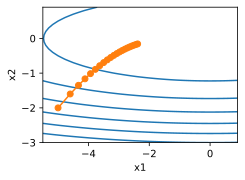

In [ ]:
def adagrad_2d(x1, x2, s1, s2):
    eps = 1e-6
    g1, g2 = 0.2 * x1, 4 * x2
    s1 += g1 ** 2
    s2 += g2 ** 2
    x1 -= eta / math.sqrt(s1 + eps) * g1
    x2 -= eta / math.sqrt(s2 + eps) * g2
    return x1, x2, s1, s2

def f_2d(x1, x2):
    return 0.1 * x1 ** 2 + 2 * x2 ** 2

eta = 0.4
d2l.show_trace_2d(f_2d, d2l.train_2d(adagrad_2d))

As we increase the learning rate to $2$ we see much better behavior. This already indicates that the decrease in learning rate might be rather aggressive, even in the noise-free case and we need to ensure that parameters converge appropriately.


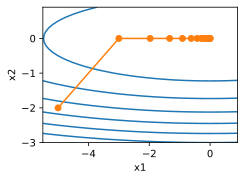

In [ ]:
eta = 2
d2l.show_trace_2d(f_2d, d2l.train_2d(adagrad_2d))

### Implementation from Scratch

Just like the momentum method, Adagrad needs to maintain a state variable of the same shape as the parameters.


In [ ]:
def init_adagrad_states(feature_dim):
    s_w = torch.zeros((feature_dim, 1))
    s_b = torch.zeros(1)
    return (s_w, s_b)

def adagrad(params, states, hyperparams):
    eps = 1e-6
    for p, s in zip(params, states):
        with torch.no_grad():
            s[:] += torch.square(p.grad)
            p[:] -= hyperparams['lr'] * p.grad / torch.sqrt(s + eps)
        p.grad.data.zero_()

Compared to the experiment in minibatch SGD we use a
larger learning rate to train the model.


loss: 0.243, 0.018 sec/epoch


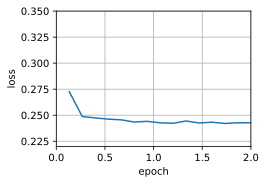

In [ ]:
data_iter, feature_dim = d2l.get_data_ch11(batch_size=10)
d2l.train_ch11(adagrad, init_adagrad_states(feature_dim),
               {'lr': 0.1}, data_iter, feature_dim);

### Concise Implementation

Using the `Trainer` instance of the algorithm `adagrad`, we can invoke the Adagrad algorithm.


loss: 0.243, 0.017 sec/epoch


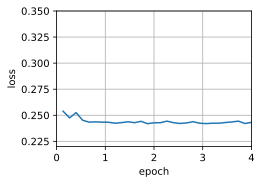

In [ ]:
trainer = torch.optim.Adagrad
d2l.train_concise_ch11(trainer, {'lr': 0.1}, data_iter)

### Summary

* Adagrad decreases the learning rate dynamically on a per-coordinate basis.
* It uses the magnitude of the gradient as a means of adjusting how quickly progress is achieved - coordinates with large gradients are compensated with a smaller learning rate.
* Computing the exact second derivative is typically infeasible in deep learning problems due to memory and computational constraints. The gradient can be a useful proxy.
* If the optimization problem has a rather uneven structure Adagrad can help mitigate the distortion.
* Adagrad is particularly effective for sparse features where the learning rate needs to decrease more slowly for infrequently occurring terms.
* On deep learning problems Adagrad can sometimes be too aggressive in reducing learning rates. We will discuss strategies for mitigating this in the context of Adam.


<a name="rmsprop"></a>
## RMSProp

One of the key issues in Adagrad is that the learning rate decreases at a predefined schedule of effectively $\mathcal{O}(t^{-\frac{1}{2}})$. While this is generally appropriate for convex problems, it might not be ideal for nonconvex ones, such as those encountered in deep learning. Yet, the coordinate-wise adaptivity of Adagrad is highly desirable as a preconditioner.

:cite:`Tieleman.Hinton.2012` proposed the RMSProp algorithm as a simple fix to decouple rate scheduling from coordinate-adaptive learning rates. The issue is that Adagrad accumulates the squares of the gradient $\mathbf{g}_t$ into a state vector $\mathbf{s}_t = \mathbf{s}_{t-1} + \mathbf{g}_t^2$. As a result $\mathbf{s}_t$ keeps on growing without bound due to the lack of normalization, essentially linearly as the algorithm converges.

One way of fixing this problem would be to use $\mathbf{s}_t / t$. For reasonable distributions of $\mathbf{g}_t$ this will converge. Unfortunately it might take a very long time until the limit behavior starts to matter since the procedure remembers the full trajectory of values. An alternative is to use a leaky average in the same way we used in the momentum method, i.e., $\mathbf{s}_t \leftarrow \gamma \mathbf{s}_{t-1} + (1-\gamma) \mathbf{g}_t^2$ for some parameter $\gamma > 0$. Keeping all other parts unchanged yields RMSProp.

### The Algorithm

Let us write out the equations in detail.

$$\begin{aligned}
    \mathbf{s}_t & \leftarrow \gamma \mathbf{s}_{t-1} + (1 - \gamma) \mathbf{g}_t^2, \\
    \mathbf{x}_t & \leftarrow \mathbf{x}_{t-1} - \frac{\eta}{\sqrt{\mathbf{s}_t + \epsilon}} \odot \mathbf{g}_t.
\end{aligned}$$

The constant $\epsilon > 0$ is typically set to $10^{-6}$ to ensure that we do not suffer from division by zero or overly large step sizes. Given this expansion we are now free to control the learning rate $\eta$ independently of the scaling that is applied on a per-coordinate basis. In terms of leaky averages we can apply the same reasoning as previously applied in the case of the momentum method. Expanding the definition of $\mathbf{s}_t$ yields

$$
\begin{aligned}
\mathbf{s}_t & = (1 - \gamma) \mathbf{g}_t^2 + \gamma \mathbf{s}_{t-1} \\
& = (1 - \gamma) \left(\mathbf{g}_t^2 + \gamma \mathbf{g}_{t-1}^2 + \gamma^2 \mathbf{g}_{t-2} + \ldots, \right).
\end{aligned}
$$

As before in Momentum we use $1 + \gamma + \gamma^2 + \ldots, = \frac{1}{1-\gamma}$. Hence the sum of weights is normalized to $1$ with a half-life time of an observation of $\gamma^{-1}$. Let us visualize the weights for the past 40 time steps for various choices of $\gamma$.


In [ ]:
from d2l import torch as d2l
import torch
import math

Text(0.5, 0, 'time')

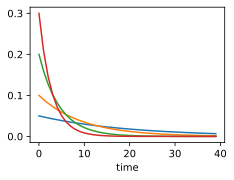

In [ ]:
d2l.set_figsize()
gammas = [0.95, 0.9, 0.8, 0.7]
for gamma in gammas:
    x = torch.arange(40).detach().numpy()
    d2l.plt.plot(x, (1 - gamma) * gamma**x, label=f'gamma = {gamma:.2f}')
d2l.plt.xlabel('time')

### Implementation from Scratch

As before we use the quadratic function $f(\mathbf{x})=0.1x_1^2+2x_2^2$ to observe the trajectory of RMSProp. Recall that in Adagrad, when we used Adagrad with a learning rate of 0.4, the variables moved only very slowly in the later stages of the algorithm since the learning rate decreased too quickly. Since $\eta$ is controlled separately this does not happen with RMSProp.


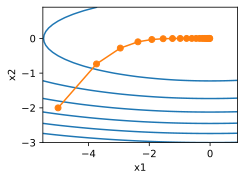

In [ ]:
def rmsprop_2d(x1, x2, s1, s2):
    g1, g2, eps = 0.2 * x1, 4 * x2, 1e-6
    s1 = gamma * s1 + (1 - gamma) * g1 ** 2
    s2 = gamma * s2 + (1 - gamma) * g2 ** 2
    x1 -= eta / math.sqrt(s1 + eps) * g1
    x2 -= eta / math.sqrt(s2 + eps) * g2
    return x1, x2, s1, s2

def f_2d(x1, x2):
    return 0.1 * x1 ** 2 + 2 * x2 ** 2

eta, gamma = 0.4, 0.9
d2l.show_trace_2d(f_2d, d2l.train_2d(rmsprop_2d))

Next, we implement RMSProp to be used in a deep network. This is equally straightforward.


In [ ]:
def init_rmsprop_states(feature_dim):
    s_w = torch.zeros((feature_dim, 1))
    s_b = torch.zeros(1)
    return (s_w, s_b)

In [ ]:
def rmsprop(params, states, hyperparams):
    gamma, eps = hyperparams['gamma'], 1e-6
    for p, s in zip(params, states):
        with torch.no_grad():
            s[:] = gamma * s + (1 - gamma) * torch.square(p.grad)
            p[:] -= hyperparams['lr'] * p.grad / torch.sqrt(s + eps)
        p.grad.data.zero_()

We set the initial learning rate to 0.01 and the weighting term $\gamma$ to 0.9. That is, $\mathbf{s}$ aggregates on average over the past $1/(1-\gamma) = 10$ observations of the square gradient.


loss: 0.246, 0.015 sec/epoch


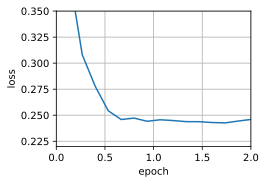

In [ ]:
data_iter, feature_dim = d2l.get_data_ch11(batch_size=10)
d2l.train_ch11(rmsprop, init_rmsprop_states(feature_dim),
               {'lr': 0.01, 'gamma': 0.9}, data_iter, feature_dim);

### Concise Implementation

Since RMSProp is a rather popular algorithm it is also available in the `Trainer` instance. All we need to do is instantiate it using an algorithm named `rmsprop`, assigning $\gamma$ to the parameter `gamma1`.


loss: 0.242, 0.016 sec/epoch


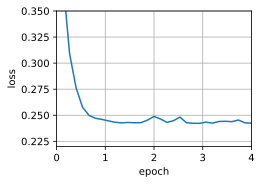

In [ ]:
trainer = torch.optim.RMSprop
d2l.train_concise_ch11(trainer, {'lr': 0.01, 'alpha': 0.9},
                       data_iter)

### Summary

* RMSProp is very similar to Adagrad insofar as both use the square of the gradient to scale coefficients.
* RMSProp shares with momentum the leaky averaging. However, RMSProp uses the technique to adjust the coefficient-wise preconditioner.
* The learning rate needs to be scheduled by the experimenter in practice.
* The coefficient $\gamma$ determines how long the history is when adjusting the per-coordinate scale.


<a name="adadelta"></a>
## Adadelta

Adadelta is yet another variant of AdaGrad. The main difference lies in the fact that it decreases the amount by which the learning rate is adaptive to coordinates. Moreover, traditionally it referred to as not having a learning rate since it uses the amount of change itself as calibration for future change. The algorithm was proposed in :cite:`Zeiler.2012`. It is fairly straightforward, given the discussion of previous algorithms so far. 



### The Algorithm

In a nutshell, Adadelta uses two state variables, $\mathbf{s}_t$ to store a leaky average of the second moment of the gradient and $\Delta\mathbf{x}_t$ to store a leaky average of the second moment of the change of parameters in the model itself. Note that we use the original notation and naming of the authors for compatibility with other publications and implementations (there is no other real reason why one should use different Greek variables to indicate a parameter serving the same purpose in momentum, Adagrad, RMSProp, and Adadelta). 

Here are the technical details of Adadelta. Given the parameter du jour is $\rho$, we obtain the following leaky updates similarly to RMSProp:

$$\begin{aligned}
    \mathbf{s}_t & = \rho \mathbf{s}_{t-1} + (1 - \rho) \mathbf{g}_t^2.
\end{aligned}$$

The difference to :numref:`sec_rmsprop` is that we perform updates with the rescaled gradient $\mathbf{g}_t'$, i.e.,

$$\begin{aligned}
    \mathbf{x}_t  & = \mathbf{x}_{t-1} - \mathbf{g}_t'. \\
\end{aligned}$$

So what is the rescaled gradient $\mathbf{g}_t'$? We can calculate it as follows:

$$\begin{aligned}
    \mathbf{g}_t' & = \frac{\sqrt{\Delta\mathbf{x}_{t-1} + \epsilon}}{\sqrt{{\mathbf{s}_t + \epsilon}}} \odot \mathbf{g}_t, \\
\end{aligned}$$

where $\Delta \mathbf{x}_{t-1}$ is the leaky average of the squared rescaled gradients $\mathbf{g}_t'$. We initialize $\Delta \mathbf{x}_{0}$ to be $0$ and update it at each step with $\mathbf{g}_t'$, i.e.,

$$\begin{aligned}
    \Delta \mathbf{x}_t & = \rho \Delta\mathbf{x}_{t-1} + (1 - \rho) {\mathbf{g}_t'}^2,
\end{aligned}$$

and $\epsilon$ (a small value such as $10^{-5}$) is added to maintain numerical stability.

### Implementation

Adadelta needs to maintain two state variables for each variable, $\mathbf{s}_t$ and $\Delta\mathbf{x}_t$. This yields the following implementation.

In [ ]:
%matplotlib inline
from d2l import torch as d2l
import torch

def init_adadelta_states(feature_dim):
    s_w, s_b = torch.zeros((feature_dim, 1)), torch.zeros(1)
    delta_w, delta_b = torch.zeros((feature_dim, 1)), torch.zeros(1)
    return ((s_w, delta_w), (s_b, delta_b))

def adadelta(params, states, hyperparams):
    rho, eps = hyperparams['rho'], 1e-5
    for p, (s, delta) in zip(params, states):
        with torch.no_grad():
            # In-place updates via [:]
            s[:] = rho * s + (1 - rho) * torch.square(p.grad)
            g = (torch.sqrt(delta + eps) / torch.sqrt(s + eps)) * p.grad
            p[:] -= g
            delta[:] = rho * delta + (1 - rho) * g * g
        p.grad.data.zero_()

Choosing $\rho = 0.9$ amounts to a half-life time of 10 for each parameter update. This tends to work quite well. We get the following behavior.


loss: 0.243, 0.017 sec/epoch


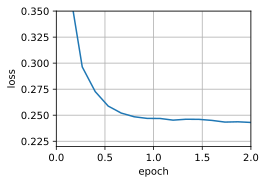

In [ ]:
data_iter, feature_dim = d2l.get_data_ch11(batch_size=10)
d2l.train_ch11(adadelta, init_adadelta_states(feature_dim),
               {'rho': 0.9}, data_iter, feature_dim);

For a concise implementation we simply use the `adadelta` algorithm from the `Trainer` class. This yields the following one-liner for a much more compact invocation.


loss: 0.243, 0.016 sec/epoch


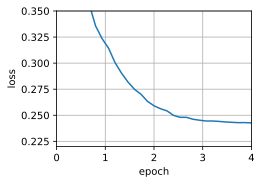

In [ ]:
trainer = torch.optim.Adadelta
d2l.train_concise_ch11(trainer, {'rho': 0.9}, data_iter)

### Summary

* Adadelta has no learning rate parameter. Instead, it uses the rate of change in the parameters itself to adapt the learning rate. 
* Adadelta requires two state variables to store the second moments of gradient and the change in parameters. 
* Adadelta uses leaky averages to keep a running estimate of the appropriate statistics. 


<a name="adam"></a>
## Adam

In the discussions leading up to this section we encountered a number of techniques for efficient optimization. Let us recap them in detail here:

* We saw that SGD is more effective than Gradient Descent when solving optimization problems, e.g., due to its inherent resilience to redundant data. 
* We saw that Minibatch SGD affords significant additional efficiency arising from vectorization, using larger sets of observations in one minibatch. This is the key to efficient multi-machine, multi-GPU and overall parallel processing. 
* Momentum added a mechanism for aggregating a history of past gradients to accelerate convergence.
* Adagrad used per-coordinate scaling to allow for a computationally efficient preconditioner. 
* RMSProp decoupled per-coordinate scaling from a learning rate adjustment. 

Adam :cite:`Kingma.Ba.2014` combines all these techniques into one efficient learning algorithm. As expected, this is an algorithm that has become rather popular as one of the more robust and effective optimization algorithms to use in deep learning. It is not without issues, though. In particular, :cite:`Reddi.Kale.Kumar.2019` show that there are situations where Adam can diverge due to poor variance control. In a follow-up work :cite:`Zaheer.Reddi.Sachan.ea.2018` proposed a hotfix to Adam, called Yogi which addresses these issues. More on this later. For now let us review the Adam algorithm. 


### The Algorithm

One of the key components of Adam is that it uses exponential weighted moving averages (also known as leaky averaging) to obtain an estimate of both the momentum and also the second moment of the gradient. That is, it uses the state variables

$$
\begin{aligned}
    \mathbf{v}_t & \leftarrow \beta_1 \mathbf{v}_{t-1} + (1 - \beta_1) \mathbf{g}_t, \\
    \mathbf{s}_t & \leftarrow \beta_2 \mathbf{s}_{t-1} + (1 - \beta_2) \mathbf{g}_t^2.
\end{aligned}
$$

Here $\beta_1$ and $\beta_2$ are nonnegative weighting parameters. Common choices for them are $\beta_1 = 0.9$ and $\beta_2 = 0.999$. That is, the variance estimate moves *much more slowly* than the momentum term. Note that if we initialize $\mathbf{v}_0 = \mathbf{s}_0 = 0$ we have a significant amount of bias initially towards smaller values. This can be addressed by using the fact that $\sum_{i=0}^t \beta^i = \frac{1 - \beta^t}{1 - \beta}$ to re-normalize terms. Correspondingly the normalized state variables are given by 

$$
\hat{\mathbf{v}}_t = \frac{\mathbf{v}_t}{1 - \beta_1^t} \text{ and } \hat{\mathbf{s}}_t = \frac{\mathbf{s}_t}{1 - \beta_2^t}.
$$

Armed with the proper estimates we can now write out the update equations. First, we rescale the gradient in a manner very much akin to that of RMSProp to obtain

$$
\mathbf{g}_t' = \frac{\eta \hat{\mathbf{v}}_t}{\sqrt{\hat{\mathbf{s}}_t} + \epsilon}.
$$

Unlike RMSProp our update uses the momentum $\hat{\mathbf{v}}_t$ rather than the gradient itself. Moreover, there is a slight cosmetic difference as the rescaling happens using $\frac{1}{\sqrt{\hat{\mathbf{s}}_t} + \epsilon}$ instead of $\frac{1}{\sqrt{\hat{\mathbf{s}}_t + \epsilon}}$. The former works arguably slightly better in practice, hence the deviation from RMSProp. Typically we pick $\epsilon = 10^{-6}$ for a good trade-off between numerical stability and fidelity. 

Now we have all the pieces in place to compute updates. This is slightly anticlimactic and we have a simple update of the form

$$
\mathbf{x}_t \leftarrow \mathbf{x}_{t-1} - \mathbf{g}_t'.
$$

Reviewing the design of Adam its inspiration is clear. Momentum and scale are clearly visible in the state variables. Their rather peculiar definition forces us to debias terms (this could be fixed by a slightly different initialization and update condition). Second, the combination of both terms is pretty straightforward, given RMSProp. Last, the explicit learning rate $\eta$ allows us to control the step length to address issues of convergence. 


### Implementation 

Implementing Adam from scratch is not very daunting. For convenience we store the time step counter $t$ in the `hyperparams` dictionary. Beyond that all is straightforward.

In [ ]:
%matplotlib inline
from d2l import torch as d2l
import torch

def init_adam_states(feature_dim):
    v_w, v_b = torch.zeros((feature_dim, 1)), torch.zeros(1)
    s_w, s_b = torch.zeros((feature_dim, 1)), torch.zeros(1)
    return ((v_w, s_w), (v_b, s_b))

def adam(params, states, hyperparams):
    beta1, beta2, eps = 0.9, 0.999, 1e-6
    for p, (v, s) in zip(params, states):
        with torch.no_grad():
            v[:] = beta1 * v + (1 - beta1) * p.grad
            s[:] = beta2 * s + (1 - beta2) * torch.square(p.grad)
            v_bias_corr = v / (1 - beta1 ** hyperparams['t'])
            s_bias_corr = s / (1 - beta2 ** hyperparams['t'])
            p[:] -= hyperparams['lr'] * v_bias_corr / (torch.sqrt(s_bias_corr)
                                                       + eps)
        p.grad.data.zero_()
    hyperparams['t'] += 1

We are ready to use Adam to train the model. We use a learning rate of $\eta = 0.01$.


loss: 0.245, 0.017 sec/epoch


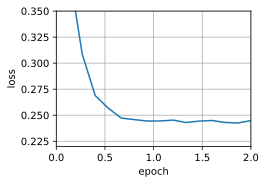

In [ ]:
data_iter, feature_dim = d2l.get_data_ch11(batch_size=10)
d2l.train_ch11(adam, init_adam_states(feature_dim),
               {'lr': 0.01, 't': 1}, data_iter, feature_dim);

A more concise implementation is straightforward since `adam` is one of the algorithms provided as part of the Gluon `trainer` optimization library. Hence we only need to pass configuration parameters for an implementation in Gluon.


loss: 0.243, 0.016 sec/epoch


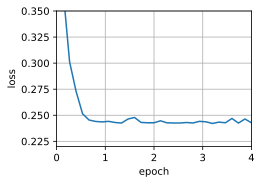

In [ ]:
trainer = torch.optim.Adam
d2l.train_concise_ch11(trainer, {'lr': 0.01}, data_iter)

### Yogi

One of the problems of Adam is that it can fail to converge even in convex settings when the second moment estimate in $\mathbf{s}_t$ blows up. As a fix :cite:`Zaheer.Reddi.Sachan.ea.2018` proposed a refined update (and initialization) for $\mathbf{s}_t$. To understand what's going on, let us rewrite the Adam update as follows:

$$\mathbf{s}_t \leftarrow \mathbf{s}_{t-1} + (1 - \beta_2) \left(\mathbf{g}_t^2 - \mathbf{s}_{t-1}\right).$$

Whenever $\mathbf{g}_t^2$ has high variance or updates are sparse, $\mathbf{s}_t$ might forget past values too quickly. A possible fix for this is to replace $\mathbf{g}_t^2 - \mathbf{s}_{t-1}$ by $\mathbf{g}_t^2 \odot \mathop{\mathrm{sgn}}(\mathbf{g}_t^2 - \mathbf{s}_{t-1})$. Now the magnitude of the update no longer depends on the amount of deviation. This yields the Yogi updates

$$\mathbf{s}_t \leftarrow \mathbf{s}_{t-1} + (1 - \beta_2) \mathbf{g}_t^2 \odot \mathop{\mathrm{sgn}}(\mathbf{g}_t^2 - \mathbf{s}_{t-1}).$$

The authors furthermore advise to initialize the momentum on a larger initial batch rather than just initial pointwise estimate. We omit the details since they are not material to the discussion and since even without this convergence remains pretty good.


loss: 0.243, 0.019 sec/epoch


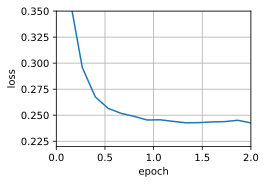

In [ ]:
def yogi(params, states, hyperparams):
    beta1, beta2, eps = 0.9, 0.999, 1e-3
    for p, (v, s) in zip(params, states):
        with torch.no_grad():
            v[:] = beta1 * v + (1 - beta1) * p.grad
            s[:] = s + (1 - beta2) * torch.sign(
                torch.square(p.grad) - s) * torch.square(p.grad)
            v_bias_corr = v / (1 - beta1 ** hyperparams['t'])
            s_bias_corr = s / (1 - beta2 ** hyperparams['t'])
            p[:] -= hyperparams['lr'] * v_bias_corr / (torch.sqrt(s_bias_corr)
                                                       + eps)
        p.grad.data.zero_()
    hyperparams['t'] += 1

data_iter, feature_dim = d2l.get_data_ch11(batch_size=10)
d2l.train_ch11(yogi, init_adam_states(feature_dim),
               {'lr': 0.01, 't': 1}, data_iter, feature_dim);

### Summary

* Adam combines features of many optimization algorithms into a fairly robust update rule. 
* Created on the basis of RMSProp, Adam also uses EWMA on the minibatch stochastic gradient.
* Adam uses bias correction to adjust for a slow startup when estimating momentum and a second moment. 
* For gradients with significant variance we may encounter issues with convergence. They can be amended by using larger minibatches or by switching to an improved estimate for $\mathbf{s}_t$. Yogi offers such an alternative. 


## Demos

[Demos](https://bl.ocks.org/EmilienDupont/aaf429be5705b219aaaf8d691e27ca87)

# Simple questions for deeper understanding

## [Stochastic Gradient Descent](#sgd) exercises

1. Experiment with different learning rate schedules for SGD and with different numbers of iterations. In particular, plot the distance from the optimal solution $(0, 0)$ as a function of the number of iterations.
1. Prove that for the function $f(x_1, x_2) = x_1^2 + 2 x_2^2$ adding normal noise to the gradient is equivalent to minimizing a loss function $l(\mathbf{x}, \mathbf{w}) = (x_1 - w_1)^2 + 2 (x_2 - w_2)^2$ where $x$ is drawn from a normal distribution.
    * Derive mean and variance of the distribution for $\mathbf{x}$.
    * Show that this property holds in general for objective functions $f(\mathbf{x}) = \frac{1}{2} (\mathbf{x} - \mathbf{\mu})^\top Q (\mathbf{x} - \mathbf{\mu})$ for $Q \succeq 0$.
1. Compare convergence of SGD when you sample from $\{(x_1, y_1), \ldots, (x_m, y_m)\}$ with replacement and when you sample without replacement.
1. How would you change the SGD solver if some gradient (or rather some coordinate associated with it) was consistently larger than all other gradients?
1. Assume that $f(x) = x^2 (1 + \sin x)$. How many local minima does $f$ have? Can you change $f$ in such a way that to minimize it one needs to evaluate all local minima?

## [Minibatch stochastic gradient descent](#minibatchsgd) exercises


1. Modify the batch size and learning rate and observe the rate of decline for the value of the objective function and the time consumed in each epoch.
1. Read the MXNet documentation and use the `Trainer` class `set_learning_rate` function to reduce the learning rate of the minibatch SGD to 1/10 of its previous value after each epoch.
1. Compare minibatch SGD with a variant that actually *samples with replacement* from the training set. What happens?
1. An evil genie replicates your dataset without telling you (i.e., each observation occurs twice and your dataset grows to twice its original size, but nobody told you). How does the behavior of SGD, minibatch SGD and that of gradient descent change?


## [Momentum SGD](#momentumsgd) exercises

1. Use other combinations of momentum hyperparameters and learning rates and observe and analyze the different experimental results.
1. Try out GD and momentum for a quadratic problem where you have multiple eigenvalues, i.e., $f(x) = \frac{1}{2} \sum_i \lambda_i x_i^2$, e.g., $\lambda_i = 2^{-i}$. Plot how the values of $x$ decrease for the initialization $x_i = 1$.
1. Derive minimum value and minimizer for $h(\mathbf{x}) = \frac{1}{2} \mathbf{x}^\top \mathbf{Q} \mathbf{x} + \mathbf{x}^\top \mathbf{c} + b$.
1. What changes when we perform SGD with momentum? What happens when we use minibatch SGD with momentum? Experiment with the parameters?

## [Adagrad](#adagrad) exercises
1. Prove that for an orthogonal matrix $\mathbf{U}$ and a vector $\mathbf{c}$ the following holds: $\|\mathbf{c} - \mathbf{\delta}\|_2 = \|\mathbf{U} \mathbf{c} - \mathbf{U} \mathbf{\delta}\|_2$. Why does this mean that the magnitude of perturbations does not change after an orthogonal change of variables?
1. Try out Adagrad for $f(\mathbf{x}) = 0.1 x_1^2 + 2 x_2^2$ and also for the objective function was rotated by 45 degrees, i.e., $f(\mathbf{x}) = 0.1 (x_1 + x_2)^2 + 2 (x_1 - x_2)^2$. Does it behave differently?
1. Prove [Gerschgorin's circle theorem](https://en.wikipedia.org/wiki/Gershgorin_circle_theorem) which states that eigenvalues $\lambda_i$ of a matrix $\mathbf{M}$ satisfy $|\lambda_i - \mathbf{M}_{jj}| \leq \sum_{k \neq j} |\mathbf{M}_{jk}|$ for at least one choice of $j$.
1. What does Gerschgorin's theorem tell us about the eigenvalues of the diagonally preconditioned matrix $\mathrm{diag}^{-\frac{1}{2}}(\mathbf{M}) \mathbf{M} \mathrm{diag}^{-\frac{1}{2}}(\mathbf{M})$?
1. Try out Adagrad for a proper deep network, such as :numref:`sec_lenet` when applied to Fashion MNIST.
1. How would you need to modify Adagrad to achieve a less aggressive decay in learning rate?

## [RMSProp](#rmsprop) exercises
1. What happens experimentally if we set $\gamma = 1$? Why?
1. Rotate the optimization problem to minimize $f(\mathbf{x}) = 0.1 (x_1 + x_2)^2 + 2 (x_1 - x_2)^2$. What happens to the convergence?
1. Try out what happens to RMSProp on a real machine learning problem, such as training on Fashion-MNIST. Experiment with different choices for adjusting the learning rate.
1. Would you want to adjust $\gamma$ as optimization progresses? How sensitive is RMSProp to this?

## [Adadelta](#adadelta) exercises
1. Adjust the value of $\rho$. What happens?
1. Show how to implement the algorithm without the use of $\mathbf{g}_t'$. Why might this be a good idea?
1. Is Adadelta really learning rate free? Could you find optimization problems that break Adadelta?
1. Compare Adadelta to Adagrad and RMSprop to discuss their convergence behavior.

## [Adam](#adam) exercises

1. Adjust the learning rate and observe and analyze the experimental results.
1. Can you rewrite momentum and second moment updates such that it does not require bias correction?
1. Why do you need to reduce the learning rate $\eta$ as we converge?
1. Try to construct a case for which Adam diverges and Yogi converges?